In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
%matplotlib inline

import torch.optim.lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seed for reproducibility
#seed = 20
#torch.manual_seed(seed)
#np.random.seed(seed)

############################ CITATION ################################

# https://github.com/ComputationalDomain/PINNs/blob/main/ODE_Neural_Networks.ipynb

# PyTorch documentation

######################## End of CITATION #############################

start_time = time.time()

torch.set_default_dtype(torch.float64)

num_count_gpu = torch.cuda.device_count()
print(num_count_gpu)

def check_tensor_cores(compute_capability):
    major, minor = compute_capability
    # Tensor cores are available in Turing (7.x) and Ampere (8.x) architectures
    if major >= 7:
        return True
    return False

# Get the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    # Get GPU properties
    device_properties = torch.cuda.get_device_properties(device)
    compute_capability = (device_properties.major, device_properties.minor)

    # Check for Tensor cores
    tensor_cores_available = check_tensor_cores(compute_capability)

    # Print GPU details
    print(f"GPU Name: {torch.cuda.get_device_name(device)}")
    print(f"Compute Capability: {compute_capability[0]}:{compute_capability[1]}")
    print(f"Tensor Cores Available: {'Yes' if tensor_cores_available else 'No'}")
else:
    print("CUDA is not available on this device.")

1
GPU Name: NVIDIA GeForce RTX 2060
Compute Capability: 7:5
Tensor Cores Available: Yes


In [2]:
n = 10
d = 2
B = 2.5
R0 = 2.2258
N = 101

n = torch.tensor(n).to(device)
d = torch.tensor(d).to(device)
B = torch.tensor(B).to(device)
R0 = torch.tensor(R0).to(device)

a1 = 15
a2 = 20
a3 = 15

In [3]:
class NN_structure(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(1, a1)
        self.hidden_layer2 = nn.Linear(a1, a2)
        self.hidden_layer3 = nn.Linear(a2, a3)
        self.output_layer = nn.Linear(a3, 1)
        
    def forward(self, x):
        x = torch.tanh(self.hidden_layer1(x))
        x = torch.tanh(self.hidden_layer2(x))
        x = torch.tanh(self.hidden_layer3(x))
        output = self.output_layer(x)
        return output
    
NN_2D_Stationary = NN_structure()
NN_2D_Stationary = NN_2D_Stationary.to(device)
scaler = GradScaler()

In [4]:
def normalized_integral(x, y, dy_dx, y_double_prime):
    # Calculate the spacing
    dx = torch.diff(x,dim=0)

    #print(x.size(), ((torch.pow(n * x - R0 * x + n + R0, 0.2e1) * B * B * torch.pow(-(n * x - R0 * x + n + R0) / (-0.1e1 + x), -(2 * d)) * torch.pow(y, 0.6e1) - y * y * torch.pow(-0.1e1 + x, 0.2e1) - torch.pow(-0.1e1 + x, 0.5e1) * (n * d - n * x + R0 * x - 0.2e1 * n - R0) * dy_dx * y * torch.pow(n, -0.2e1) / (n * x - R0 * x + n + R0) / 0.2e1 + torch.pow(-0.1e1 + x, 0.6e1) * y_double_prime * y * torch.pow(n, -0.2e1) / 0.4e1 - torch.pow(-0.1e1 + x, 0.6e1) * dy_dx * dy_dx * torch.pow(n, -0.2e1) / 0.2e1 + torch.pow(-0.1e1 + x, 0.2e1))**2)[:-1].size(),dx.size())
    
    # Weighted mean calculation
    
    #weighted_sum = torch.sum(((torch.pow(n * x - R0 * x + n + R0, 0.2e1) * B * B * torch.pow(-(n * x - R0 * x + n + R0) / (-0.1e1 + x), -(2 * d)) * torch.pow(y * (-x * x + 0.1e1) + 0.1e1 / 0.2e1 + x / 0.2e1, 0.5e1) * torch.pow(-0.1e1 + x, -0.2e1) - y * (-x * x + 0.1e1) - 0.1e1 / 0.2e1 - x / 0.2e1 - torch.pow(-0.1e1 + x, 0.3e1) * (n * d - n * x + R0 * x - 0.2e1 * n - R0) * (dy_dx * (-x * x + 0.1e1) - 0.2e1 * y * x + 0.1e1 / 0.2e1) * torch.pow(n, -0.2e1) / (n * x - R0 * x + n + R0) / 0.2e1 + torch.pow(-0.1e1 + x, 0.4e1) * (d * (-x * x + 0.1e1) - 0.4e1 * dy_dx * x - 0.2e1 * y) * torch.pow(n, -0.2e1) / 0.4e1 + (-torch.pow(-0.1e1 + x, 0.4e1) * torch.pow(dy_dx * (-x * x + 0.1e1) - 0.2e1 * y * x + 0.1e1 / 0.2e1, 0.2e1) * torch.pow(n, -0.2e1) / 0.2e1 + 0.1e1) / (y * (-x * x + 0.1e1) + 0.1e1 / 0.2e1 + x / 0.2e1))**2)[:-1] * dx)
    #weighted_sum = torch.sum(((torch.pow(n * x - R0 * x + n + R0, 0.2e1) * B * B * torch.pow(-(n * x - R0 * x + n + R0) / (-0.1e1 + x), -(2 * d)) * torch.pow(y, 0.5e1) * torch.pow(-0.1e1 + x, -0.2e1) - y - torch.pow(-0.1e1 + x, 0.3e1) * (n * d - n * x + R0 * x - 0.2e1 * n - R0) * dy_dx * torch.pow(n, -0.2e1) / (n * x - R0 * x + n + R0) / 0.2e1 + torch.pow(-0.1e1 + x, 0.4e1) * y_double_prime * torch.pow(n, -0.2e1) / 0.4e1 + (-torch.pow(-0.1e1 + x, 0.4e1) * dy_dx * dy_dx * torch.pow(n, -0.2e1) / 0.2e1 + 0.1e1) / y)**2)[:-1] * dx)
    
    #weighted_sum = torch.sum(((torch.pow(n * x - R0 * x + n + R0, 0.2e1) * B * B * torch.pow(-(n * x - R0 * x + n + R0) / (-0.1e1 + x), -(2 * d)) * torch.pow((-x * x + 0.1e1) * y + 0.1e1 / 0.2e1 + x / 0.2e1, 0.6e1) - torch.pow((-x * x + 0.1e1) * y + 0.1e1 / 0.2e1 + x / 0.2e1, 0.2e1) * torch.pow(-0.1e1 + x, 0.2e1) - torch.pow(-0.1e1 + x, 0.5e1) * (n * d - n * x + R0 * x - 0.2e1 * n - R0) * (-0.2e1 * x * y + (-x * x + 0.1e1) * dy_dx + 0.1e1 / 0.2e1) * torch.pow(n, -0.2e1) / (n * x - R0 * x + n + R0) * ((-x * x + 0.1e1) * y + 0.1e1 / 0.2e1 + x / 0.2e1) / 0.2e1 + torch.pow(-0.1e1 + x, 0.6e1) * (-0.2e1 * y - 0.4e1 * x * dy_dx + (-x * x + 0.1e1) * y_double_prime) * torch.pow(n, -0.2e1) * ((-x * x + 0.1e1) * y + 0.1e1 / 0.2e1 + x / 0.2e1) / 0.4e1 - torch.pow(-0.1e1 + x, 0.6e1) * torch.pow(-0.2e1 * x * y + (-x * x + 0.1e1) * dy_dx + 0.1e1 / 0.2e1, 0.2e1) * torch.pow(n, -0.2e1) / 0.2e1 + torch.pow(-0.1e1 + x, 0.2e1))**2)[:-1] * dx)
    weighted_sum = torch.sum(((torch.pow(n * x - R0 * x + n + R0, 0.2e1) * B * B * torch.pow(-(n * x - R0 * x + n + R0) / (-0.1e1 + x), -(2 * d)) * torch.pow(y, 0.6e1) - y * y * torch.pow(-0.1e1 + x, 0.2e1) - torch.pow(-0.1e1 + x, 0.5e1) * (n * d - n * x + R0 * x - 0.2e1 * n - R0) * dy_dx * torch.pow(n, -0.2e1) / (n * x - R0 * x + n + R0) * y / 0.2e1 + torch.pow(-0.1e1 + x, 0.6e1) * y_double_prime * torch.pow(n, -0.2e1) * y / 0.4e1 - torch.pow(-0.1e1 + x, 0.6e1) * dy_dx * dy_dx * torch.pow(n, -0.2e1) / 0.2e1 + torch.pow(-0.1e1 + x, 0.2e1))**2)[:-1] * dx)
    
    total_length = torch.sum(dx)
    mean_value = weighted_sum / total_length
    
    return mean_value

def loss(x):
    x.requires_grad = True
    with autocast():
        y = ((NN_2D_Stationary(x.to(device)) * (-x * x + 1)) + 0.5*(1+x))
        dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0].to(device)
        y_double_prime = torch.autograd.grad(dy_dx.sum(), x, create_graph=True)[0].to(device)

    #print(x.size(),y.size(),dy_dx.size(),y_double_prime.size())
    
    mean_result = normalized_integral(x, y, dy_dx, y_double_prime)
    
    return mean_result

In [5]:
optimizer = torch.optim.Adam(NN_2D_Stationary.parameters(), lr=0.01)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=100, min_lr=0.00001)

x = torch.cos(torch.linspace(np.pi, 0, N))[:, None].to(device)
#print(x)
#print(torch.diff(x)[:, None])

#x = x[1:-1]

print(x.size())

def optimizer_and_loss():
    optimizer.zero_grad()
    with autocast():
        l = loss(x)
    scaler.scale(l).backward()
    scaler.step(optimizer)
    scaler.update()
    return l

loss_threshold = 1e-8  # Set your desired loss threshold here
current_loss = float('inf')  # Initialize with a large value

i = 0
while current_loss > loss_threshold:
    optimizer.step(optimizer_and_loss)
    current_loss = optimizer_and_loss().item()  # Update current loss value
    scheduler.step(current_loss)
    
    if i % 1000 == 0:
        print(optimizer_and_loss().item(), optimizer.param_groups[0]['lr'])

    i += 1

print(i)

for name, param in NN_2D_Stationary.named_parameters():
    print(f"Parameter: {name} | Shape: {param.shape} | Values: {param}")

torch.Size([101, 1])
0.49524852002698694 0.01
0.0007366667277515283 0.008100000000000001
0.0001111821587422849 0.004304672100000002
7.177917144732623e-05 0.0025418658283290017
5.531613177805734e-06 0.001215766545905694
1.4571438188204014e-05 0.0006461081889226679
2.047350212443485e-06 0.00034336838202925164
2.3120313835617794e-06 0.00020275559590445286
1.0554689128442557e-06 0.00013302794647291155
8.311287139285904e-07 7.855167211278955e-05
5.485548222858908e-07 6.362685441135955e-05
6.406081148246029e-07 5.7264168970223595e-05
3.868554900666086e-07 4.1745579179293e-05
3.271168671422705e-07 3.381391913522733e-05
2.852333696676063e-07 3.0432527221704597e-05
3.04041812601592e-07 3.0432527221704597e-05
2.25002408990363e-07 2.218531234462265e-05
2.0121430787102176e-07 2.218531234462265e-05
1.916009016626868e-07 1.797010299914435e-05
1.5284500475384654e-07 1.310020508637623e-05
1.4030393851757154e-07 1.310020508637623e-05
1.2850435250255564e-07 1.310020508637623e-05
1.2964412349729237e-07 1

In [6]:
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Elapsed Time: 2400.24 seconds


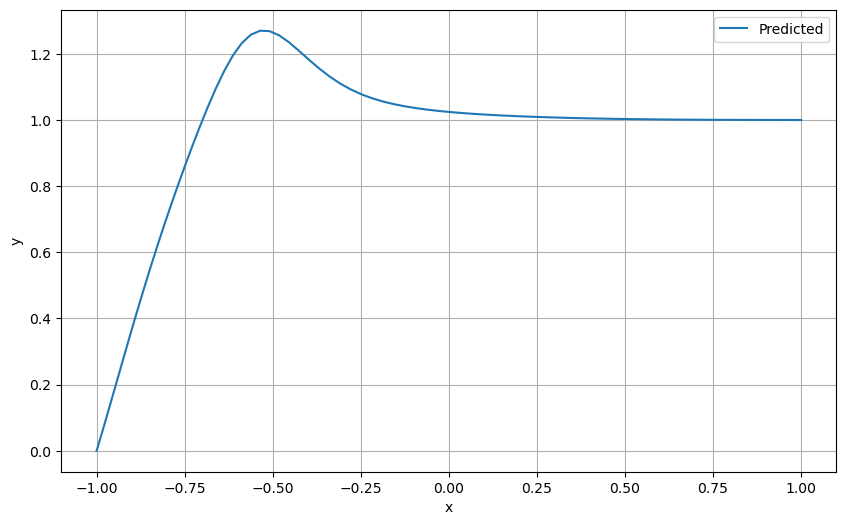

In [11]:
import matplotlib.pyplot as plt

with torch.no_grad():
    xx = x.to(device)
    yy = ((NN_2D_Stationary(xx.to(device)) * (-(xx.to(device)) * (xx.to(device)) + 1)) + 0.5*(1+(xx.to(device))))

xx = xx.detach().cpu().numpy()
yy = yy.detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(xx, yy, label="Predicted")
#plt.plot(xx, 0.10e2 * np.sqrt(0.10016e0 + 0.8e-3 * xx + 0.1e-2 * pow(xx, 2)), '--', label="Exact")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()

In [12]:
# Save x and y to a text file
with open('B_2.5_R0_2.2258_stationary_sol_NN_init_satisfy_bc_TensorCores.txt', 'w') as f:
    for i in range(len(xx)):
        f.write(f"{xx[i].item()} {yy[i].item()}\n")